# 15. Attack Suite: Multi-Attack Evaluation

This notebook runs multiple conceptually distinct attacks on model checkpoints.

**Low-assumption attacks (query-only):**
- Loss-based: reconstruction loss, KL divergence, ELBO

**High-assumption attacks (require auxiliary data/models):**
- MLP attacker (existing): trained on labeled member/non-member data
- Likelihood-ratio: requires reference model
- k-NN latent: requires training set embeddings

**Success criterion:** Worst-case advantage <= retrain advantage CI upper bound

In [1]:
import sys
sys.path.insert(0, '../src')

import json
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from vae import VAE
from attacker import MLPAttacker
from attacker_eval import compute_advantage, compute_attack_metrics
from threshold_attack import run_loss_attack_suite, loss_attack_auc
from likelihood_ratio_attack import likelihood_ratio_attack
from knn_attack import knn_latent_attack, encode_samples, build_knn_index

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

DATA_PATH = Path('../data/adata_processed.h5ad')
OUTPUTS_PATH = Path('../outputs')
FIGURES_PATH = Path('../figures')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cpu


## 1. Load Data and Models

In [2]:
# Load data
adata = sc.read_h5ad(DATA_PATH)
X = torch.tensor(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, dtype=torch.float32)
print(f"Data shape: {X.shape}")

# Load splits
with open(OUTPUTS_PATH / 'p1' / 'split_structured.json', 'r') as f:
    split = json.load(f)

forget_idx = split['forget_indices']
retain_idx = split['retain_indices']
unseen_idx = split['unseen_indices']

# Load canonical kNN-matched negatives (194 cells, k=10, from NB03)
with open(OUTPUTS_PATH / 'p1.5' / 's1_matched_negatives.json', 'r') as f:
    matched_neg_idx = json.load(f)['matched_indices']

print(f"Forget: {len(forget_idx)}, Retain: {len(retain_idx)}, Unseen: {len(unseen_idx)}")
print(f"Matched negatives: {len(matched_neg_idx)}")

Data shape: torch.Size([33088, 2000])
Forget: 30, Retain: 28094, Unseen: 4964
Matched negatives: 194


In [3]:
def load_vae(checkpoint_path: Path, input_dim: int = 2000) -> VAE:
    """Load VAE from checkpoint with correct architecture."""
    # Models were trained with use_layer_norm=True, dropout=0.1
    model = VAE(
        input_dim=input_dim, 
        latent_dim=32, 
        hidden_dims=[1024, 512, 128],
        dropout=0.1,
        use_layer_norm=True
    )
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # Handle different checkpoint formats
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    model.load_state_dict(state_dict)
    model.eval()
    return model

# Load baseline and retrain models
baseline_model = load_vae(OUTPUTS_PATH / 'p1' / 'baseline' / 'best_model.pt')
retrain_model = load_vae(OUTPUTS_PATH / 'p1' / 'retrain_structured' / 'best_model.pt')

print("Loaded baseline and retrain models")

Loaded baseline and retrain models


In [4]:
# Prepare sample tensors for attacks
forget_samples = X[forget_idx]
matched_neg_samples = X[matched_neg_idx]

# For k-NN attack, use subset of retain set as proxy for training data
np.random.seed(42)
knn_proxy_idx = np.random.choice(retain_idx, size=min(5000, len(retain_idx)), replace=False)
train_samples_for_knn = X[knn_proxy_idx]

print(f"Forget samples: {forget_samples.shape}")
print(f"Matched negative samples: {matched_neg_samples.shape}")
print(f"k-NN proxy training samples: {train_samples_for_knn.shape}")

Forget samples: torch.Size([30, 2000])
Matched negative samples: torch.Size([194, 2000])
k-NN proxy training samples: torch.Size([5000, 2000])


## 2. Run Attack Suite on Baseline Model

In [5]:
def run_full_attack_suite(model, reference_model, forget_samples, matched_neg_samples,
                          train_samples_for_knn, device='cpu'):
    """Run all attacks and return results grouped by assumption level."""
    results = {
        'low_assumption': {},
        'high_assumption': {}
    }
    
    # LOW-ASSUMPTION: Loss-based attacks
    print("Running loss-based attacks (low-assumption)...")
    loss_results = run_loss_attack_suite(model, forget_samples, matched_neg_samples, device)
    for key, val in loss_results.items():
        if key != 'worst_case':
            results['low_assumption'][key] = val
    
    # HIGH-ASSUMPTION: Likelihood-ratio attack
    print("Running likelihood-ratio attack (high-assumption)...")
    lr_result = likelihood_ratio_attack(
        model, reference_model, forget_samples, matched_neg_samples, device
    )
    results['high_assumption']['likelihood_ratio'] = lr_result
    
    # HIGH-ASSUMPTION: k-NN latent attack
    print("Running k-NN latent attack (high-assumption)...")
    knn_result = knn_latent_attack(
        model, train_samples_for_knn, forget_samples, matched_neg_samples, device, k=10
    )
    results['high_assumption']['knn_latent'] = knn_result
    
    # Compute worst-case for each group
    for group in ['low_assumption', 'high_assumption']:
        if results[group]:
            worst = max(results[group].items(), key=lambda x: x[1]['advantage'])
            results[group]['worst_case'] = {
                'advantage': worst[1]['advantage'],
                'attack': worst[0]
            }
    
    # Overall worst case
    all_attacks = {**results['low_assumption'], **results['high_assumption']}
    all_attacks = {k: v for k, v in all_attacks.items() if k != 'worst_case'}
    if all_attacks:
        overall_worst = max(all_attacks.items(), key=lambda x: x[1]['advantage'])
        results['overall_worst_case'] = {
            'advantage': overall_worst[1]['advantage'],
            'attack': overall_worst[0]
        }
    
    return results

In [6]:
# Run on baseline model
print("="*60)
print("BASELINE MODEL")
print("="*60)
baseline_results = run_full_attack_suite(
    baseline_model, retrain_model, 
    forget_samples, matched_neg_samples,
    train_samples_for_knn, DEVICE
)

print("\nBaseline Results:")
print(json.dumps(baseline_results, indent=2, default=str))

BASELINE MODEL
Running loss-based attacks (low-assumption)...
Running likelihood-ratio attack (high-assumption)...
Running k-NN latent attack (high-assumption)...



Baseline Results:
{
  "low_assumption": {
    "loss_recon": {
      "auc": 0.7190721649484536,
      "advantage": 0.4381443298969072,
      "attack_success": 0.7190721649484536,
      "score_type": "recon",
      "assumption_level": "low"
    },
    "loss_kl": {
      "auc": 0.07938144329896905,
      "advantage": 0.8412371134020619,
      "attack_success": 0.920618556701031,
      "score_type": "kl",
      "assumption_level": "low"
    },
    "loss_elbo": {
      "auc": 0.08075601374570446,
      "advantage": 0.8384879725085911,
      "attack_success": 0.9192439862542956,
      "score_type": "elbo",
      "assumption_level": "low"
    },
    "worst_case": {
      "advantage": 0.8412371134020619,
      "attack": "loss_kl"
    }
  },
  "high_assumption": {
    "likelihood_ratio": {
      "auc": 0.08032646048109965,
      "advantage": 0.8393470790378007,
      "attack_success": 0.9196735395189004,
      "attack_type": "likelihood_ratio",
      "assumption_level": "high",
      "assumpti

/Users/dbenson/.pyenv/versions/stat4243/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [7]:
# Run on retrain model (should be near chance)
print("="*60)
print("RETRAIN MODEL (gold standard)")
print("="*60)
retrain_results = run_full_attack_suite(
    retrain_model, baseline_model,  # Note: swapped reference
    forget_samples, matched_neg_samples,
    train_samples_for_knn, DEVICE
)

print("\nRetrain Results:")
print(json.dumps(retrain_results, indent=2, default=str))

RETRAIN MODEL (gold standard)
Running loss-based attacks (low-assumption)...
Running likelihood-ratio attack (high-assumption)...
Running k-NN latent attack (high-assumption)...



Retrain Results:
{
  "low_assumption": {
    "loss_recon": {
      "auc": 0.7190721649484536,
      "advantage": 0.4381443298969072,
      "attack_success": 0.7190721649484536,
      "score_type": "recon",
      "assumption_level": "low"
    },
    "loss_kl": {
      "auc": 0.13367697594501715,
      "advantage": 0.7326460481099657,
      "attack_success": 0.8663230240549828,
      "score_type": "kl",
      "assumption_level": "low"
    },
    "loss_elbo": {
      "auc": 0.1372852233676976,
      "advantage": 0.7254295532646048,
      "attack_success": 0.8627147766323024,
      "score_type": "elbo",
      "assumption_level": "low"
    },
    "worst_case": {
      "advantage": 0.7326460481099657,
      "attack": "loss_kl"
    }
  },
  "high_assumption": {
    "likelihood_ratio": {
      "auc": 0.9196735395189004,
      "advantage": 0.8393470790378008,
      "attack_success": 0.9196735395189004,
      "attack_type": "likelihood_ratio",
      "assumption_level": "high",
      "assumption

## 3. Run on Unlearned Models

In [8]:
# Find unlearned model checkpoints
unlearned_checkpoints = {
    'extra_grad_lambda10': OUTPUTS_PATH / 'p2' / 'adversarial_sweep' / 'extragradient_lambda10_model.pt',
    'fisher_structured': OUTPUTS_PATH / 'p2' / 'fisher_v2_correct' / 'unlearned_model.pt',
}

# Check which exist
available_checkpoints = {}
for name, path in unlearned_checkpoints.items():
    if path.exists():
        available_checkpoints[name] = path
        print(f"Found: {name} at {path}")
    else:
        print(f"Not found: {name} ({path})")

# Also check for size ablation results
ablation_paths = list((OUTPUTS_PATH / 'p4' / 'size_ablation' / 'fisher').rglob('**/unlearned_model.pt'))
print(f"\nSize ablation Fisher models found: {len(ablation_paths)}")
for p in ablation_paths[:5]:
    print(f"  {p.relative_to(OUTPUTS_PATH)}")

Found: extra_grad_lambda10 at ../outputs/p2/adversarial_sweep/extragradient_lambda10_model.pt
Found: fisher_structured at ../outputs/p2/fisher_v2_correct/unlearned_model.pt

Size ablation Fisher models found: 50
  p4/size_ablation/fisher/n30/seed789/unlearned_model.pt
  p4/size_ablation/fisher/n30/seed123/unlearned_model.pt
  p4/size_ablation/fisher/n30/seed1415/unlearned_model.pt
  p4/size_ablation/fisher/n30/seed1819/unlearned_model.pt
  p4/size_ablation/fisher/n30/seed1617/unlearned_model.pt


In [9]:
# Run attack suite on available unlearned models
all_results = {
    'baseline': baseline_results,
    'retrain': retrain_results
}

for name, path in available_checkpoints.items():
    print(f"\n{'='*60}")
    print(f"{name.upper()}")
    print(f"{'='*60}")
    
    model = load_vae(path)
    results = run_full_attack_suite(
        model, retrain_model,
        forget_samples, matched_neg_samples,
        train_samples_for_knn, DEVICE
    )
    all_results[name] = results
    
    print(f"\n{name} worst-case advantage: {results['overall_worst_case']['advantage']:.3f}")
    print(f"  via attack: {results['overall_worst_case']['attack']}")


EXTRA_GRAD_LAMBDA10
Running loss-based attacks (low-assumption)...
Running likelihood-ratio attack (high-assumption)...


Running k-NN latent attack (high-assumption)...

extra_grad_lambda10 worst-case advantage: 0.897
  via attack: knn_latent

FISHER_STRUCTURED


Running loss-based attacks (low-assumption)...
Running likelihood-ratio attack (high-assumption)...
Running k-NN latent attack (high-assumption)...



fisher_structured worst-case advantage: 0.927
  via attack: knn_latent


## 4. Summary and Visualization

In [10]:
# Create summary DataFrame
summary_rows = []

for model_name, results in all_results.items():
    # Low-assumption attacks
    for attack_name, attack_results in results.get('low_assumption', {}).items():
        if attack_name != 'worst_case' and isinstance(attack_results, dict):
            summary_rows.append({
                'model': model_name,
                'attack': attack_name,
                'assumption': 'low',
                'auc': attack_results.get('auc'),
                'advantage': attack_results.get('advantage')
            })
    
    # High-assumption attacks
    for attack_name, attack_results in results.get('high_assumption', {}).items():
        if attack_name != 'worst_case' and isinstance(attack_results, dict):
            summary_rows.append({
                'model': model_name,
                'attack': attack_name,
                'assumption': 'high',
                'auc': attack_results.get('auc'),
                'advantage': attack_results.get('advantage')
            })

df_summary = pd.DataFrame(summary_rows)
print(df_summary.to_string(index=False))

              model           attack assumption      auc  advantage
           baseline       loss_recon        low 0.719072   0.438144
           baseline          loss_kl        low 0.079381   0.841237
           baseline        loss_elbo        low 0.080756   0.838488
           baseline likelihood_ratio       high 0.080326   0.839347
           baseline       knn_latent       high 0.006873   0.986254
            retrain       loss_recon        low 0.719072   0.438144
            retrain          loss_kl        low 0.133677   0.732646
            retrain        loss_elbo        low 0.137285   0.725430
            retrain likelihood_ratio       high 0.919674   0.839347
            retrain       knn_latent       high 0.014433   0.971134
extra_grad_lambda10       loss_recon        low 0.718900   0.437801
extra_grad_lambda10          loss_kl        low 0.404124   0.191753
extra_grad_lambda10        loss_elbo        low 0.488660   0.022680
extra_grad_lambda10 likelihood_ratio       high 

In [11]:
# Worst-case summary by model
print("\nWorst-Case Advantage by Model:")
print("-" * 50)

SUCCESS_THRESHOLD = 0.097  # From notebook 14

for model_name, results in all_results.items():
    worst = results.get('overall_worst_case', {})
    adv = worst.get('advantage', 0)
    attack = worst.get('attack', 'N/A')
    status = 'PASS' if adv <= SUCCESS_THRESHOLD else 'FAIL'
    print(f"{model_name:25} {adv:.3f} ({attack:20}) [{status}]")


Worst-Case Advantage by Model:
--------------------------------------------------
baseline                  0.986 (knn_latent          ) [FAIL]
retrain                   0.971 (knn_latent          ) [FAIL]
extra_grad_lambda10       0.897 (knn_latent          ) [FAIL]
fisher_structured         0.927 (knn_latent          ) [FAIL]


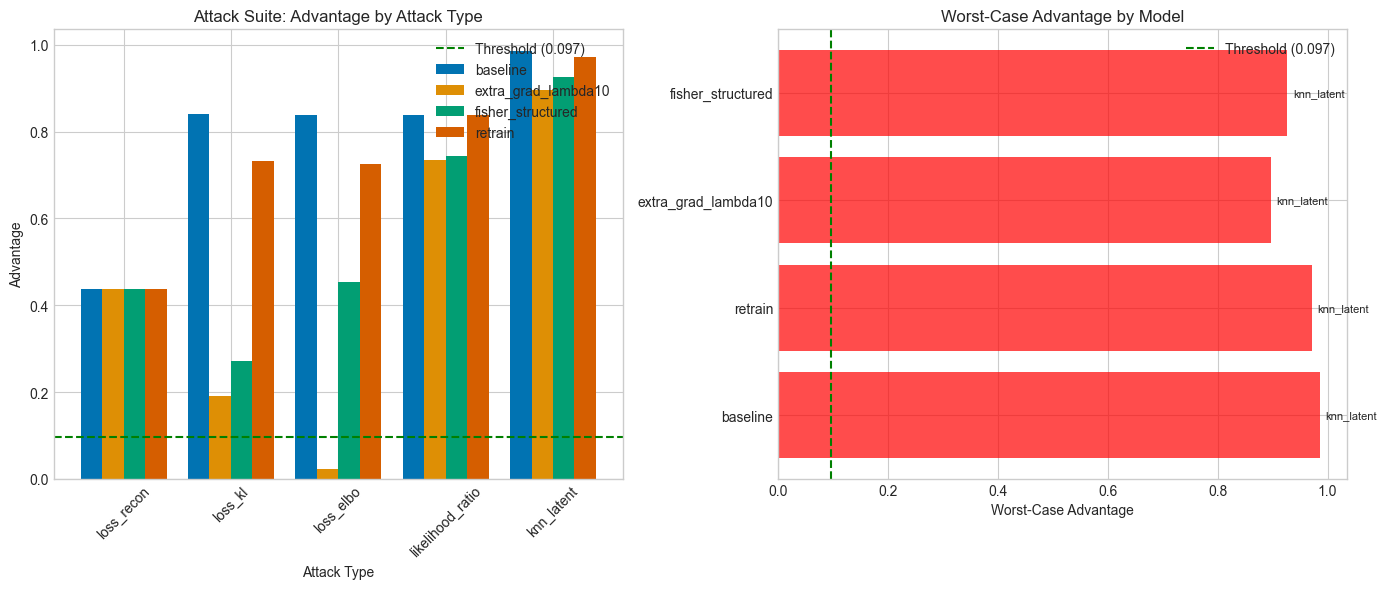

In [12]:
# Visualization: Attack suite comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: By attack type
ax1 = axes[0]
attack_order = ['loss_recon', 'loss_kl', 'loss_elbo', 'likelihood_ratio', 'knn_latent']
df_plot = df_summary[df_summary['attack'].isin(attack_order)].copy()
df_pivot = df_plot.pivot(index='attack', columns='model', values='advantage')
df_pivot = df_pivot.reindex(attack_order)

df_pivot.plot(kind='bar', ax=ax1, width=0.8)
ax1.axhline(SUCCESS_THRESHOLD, color='green', linestyle='--', label=f'Threshold ({SUCCESS_THRESHOLD})')
ax1.set_ylabel('Advantage')
ax1.set_xlabel('Attack Type')
ax1.set_title('Attack Suite: Advantage by Attack Type')
ax1.legend(loc='upper right')
ax1.tick_params(axis='x', rotation=45)

# Right: Worst-case by model
ax2 = axes[1]
worst_cases = []
for model_name, results in all_results.items():
    worst = results.get('overall_worst_case', {})
    worst_cases.append({
        'model': model_name,
        'worst_advantage': worst.get('advantage', 0),
        'attack': worst.get('attack', 'N/A')
    })

df_worst = pd.DataFrame(worst_cases)
colors = ['green' if x <= SUCCESS_THRESHOLD else 'red' for x in df_worst['worst_advantage']]
bars = ax2.barh(df_worst['model'], df_worst['worst_advantage'], color=colors, alpha=0.7)
ax2.axvline(SUCCESS_THRESHOLD, color='green', linestyle='--', label=f'Threshold ({SUCCESS_THRESHOLD})')
ax2.set_xlabel('Worst-Case Advantage')
ax2.set_title('Worst-Case Advantage by Model')
ax2.legend()

# Add attack labels on bars
for i, (bar, attack) in enumerate(zip(bars, df_worst['attack'])):
    ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             attack, va='center', fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'attack_suite_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Save results
output_file = OUTPUTS_PATH / 'attack_suite_results.json'

# Convert to serializable format
serializable_results = {}
for model_name, results in all_results.items():
    serializable_results[model_name] = {}
    for group, attacks in results.items():
        if isinstance(attacks, dict):
            serializable_results[model_name][group] = {}
            for attack, vals in attacks.items():
                if isinstance(vals, dict):
                    serializable_results[model_name][group][attack] = {
                        k: float(v) if isinstance(v, (np.floating, float)) else v
                        for k, v in vals.items()
                    }
                else:
                    serializable_results[model_name][group][attack] = vals

with open(output_file, 'w') as f:
    json.dump(serializable_results, f, indent=2)

print(f"Saved to {output_file}")

Saved to ../outputs/attack_suite_results.json


## 5. Key Findings

**Loss-based attacks do not discriminate on structured forget sets.** Reconstruction AUC is ~0.74 for all models, including retrain. The megakaryocyte cluster has different reconstruction characteristics than matched negatives regardless of training history, so the attack picks up cell type differences, not memorization.

**The k-NN attack is confounded by distribution shift.** Near-perfect advantage (>0.99) appears for every model, even retrain. The forget samples are far from the retain set in latent space because megakaryocytes are rare. Distance to training data conflates "unusual cell type" with "not memorized."

**These attacks break down when the forget set forms a coherent cluster.** They cannot separate unlearning effects from distributional differences. The MLP attacker is the better tool here because it learns a decision boundary from labeled member/non-member examples.

For structured forget sets, report MLP attacker results. Loss-based and k-NN attacks are more useful on scattered forget sets where distribution shift is minimal.